# Lesson 6 - Model interpretability

> How to interpret the predictions from Random Forest models and use these insights to prune the feature space.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson06_model-interpretation.ipynb) 
[![slides](https://img.shields.io/static/v1?label=slides&message=lesson06_model-interpretation.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=15IIYC_MksmXI6VfSL3ee-rLm7TRF0v2U)

## Learning objectives

* Understand how to interpret feature importance plots for Random Forest models.
* Know how to drop uninformative features to build simpler models

## References

This lesson is adapted (with permission) from Jeremy Howard's fantastic online course [_Introduction to Machine Learning for Coders_](https://course18.fast.ai/ml), in particular:

* [3 — Performance, validation and model interpretation](https://course18.fast.ai/lessonsml1/lesson3.html)

Below are a few relevant articles that may be of general interest:

* [Explaining Feature Importance by example of a Random Forest](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)
* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
* [Explainable AI won’t deliver. Here’s why.](https://hackernoon.com/explainable-ai-wont-deliver-here-s-why-6738f54216be)
* [Confidence Intervals](https://dfrieds.com/math/confidence-intervals.html)
* [Reading and Writing Files in Python (Guide)](https://realpython.com/read-write-files-python/)

## Homework

* Solve the exercises included in this notebook

## The data

In this lesson we will analyse the preprocessed table of clean housing data and their addresses that we prepared in lesson 3:

* `housing_processed.csv`

## What is model interpretability?

<div style="text-align: center">
<img src='images/interpretable.jpg' width='300'>
    <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/3djjWc6 </p>
</div>

A nice explanation for what it means to interpret a model's predictions is given in the _Beware Default Random Forest Importances_ article:

> Training a model that accurately predicts outcomes is great, but most of the time you don't just need predictions, you want to be able to interpret your model. For example, if you build a model of house prices, knowing which features are most predictive of price tells us which features people are willing to pay for.

In this lesson we will focus on one specific aspect of interpretability for Random Forests, namely _feature importance_ which is a technique that (with care) can be used to identify the most informative features in a dataset.

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment to update the library if working locally
# !pip install dslectures --upgrade

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from dslectures.core import get_dataset, convert_strings_to_categories, rmse, fill_missing_values_with_median
from pathlib import Path

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import scipy
from scipy.cluster import hierarchy as hc

## Load the data

As usual we can download the dataset with our helper function:

In [ ]:
get_dataset('housing_processed.csv')

Download of housing_processed.csv dataset complete.


We also make use of the `pathlib` library to handle our filepaths:

In [ ]:
DATA = Path('../data/')
!ls {DATA}

housing.csv                  imdb.csv
housing_addresses.csv        keep_cols.npy
housing_columns_to_keep.npy  submission.csv
housing_gmaps_data_raw.csv   test.csv
housing_merged.csv           train.csv
housing_model.pkl            uc
housing_processed.csv        word2vec-google-news-300.pkl


In [ ]:
housing_data = pd.read_csv(DATA/'housing_processed.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,94705,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,94611,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,94618,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,94618,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,94618,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


With the data loaded, we can recreate our train/validation splits as before:

In [ ]:
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'{len(X_train)} train rows + {len(X_valid)} valid rows')

15554 train rows + 3889 valid rows


To simplify the evaluation of our models, we'll reuse our scoring function from lesson 5:

In [ ]:
def print_rf_scores(fitted_model):
    """Generates RMSE and R^2 scores from fitted Random Forest model."""

    yhat_train = fitted_model.predict(X_train)
    R2_train = fitted_model.score(X_train, y_train)
    yhat_valid = fitted_model.predict(X_valid)
    R2_valid = fitted_model.score(X_valid, y_valid)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "R^2 on train:": R2_train,
        "RMSE on valid:": rmse(y_valid, yhat_valid),
        "R^2 on valid:": R2_valid,
    }
    if hasattr(fitted_model, "oob_score_"):
        scores["OOB R^2:"] = fitted_model.oob_score_

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

## Confidence intervals

Recall that to make predictions with our Random Forest models, we take the _average value_ in each leaf node as we pass each row in the validation set through the tree. However, we would also like to estimate our _**confidence**_ in these predictions - how can we achieve this?

One way to do this is to calculate the _**standard deviation of the predictions**_ of the trees. Conceptually, the idea is that if the standard deviation is high, each tree is generating very different predictions and may indicate the model has not learnt the most important features of the data.

To get started, let's use our baseline model from the previous lesson:

In [ ]:
model = RandomForestRegressor(n_estimators=40, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 16520.37
R^2 on train: 0.971
RMSE on valid: 42727.043
R^2 on valid: 0.81
OOB R^2: 0.791


As before, we concatenate all the predictions from each tree into a single array:

In [ ]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
# calculate mean and standard deviation for single observation
np.mean(preds[:,0]), np.std(preds[:,0])

(137125.0, 41845.23120978064)

In [ ]:
preds.shape

(40, 3889)

Next, let's create a copy of the validation dataset and add the mean predictions and their standard deviation as new columns.

---

#### Exercise #1

* Combine `X_valid` and `y_valid` into a single array called `valid_copy`. You may find the `DataFrame.join(DataFrame)` method from pandas useful here.
* Create two new columns `preds_mean` and `preds_std` that are the mean and standard deviation of the predictions for each tree in `preds`

---

We can use these new columns to drill-down into the predictions of each individual, categorical feature. Let's examine `ocean_proximity_INLAND` which denotes whether a housing district is inland or not:

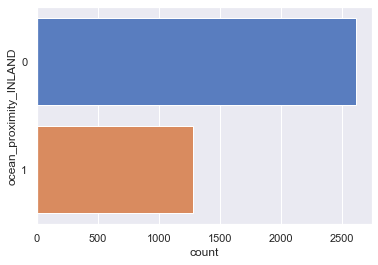

In [ ]:
sns.countplot(y='ocean_proximity_INLAND', data=valid_copy);

We can calculate the predictions and standard deviation per category by applying a _**group by**_ operation in pandas, followed by taking the mean.

In [ ]:
cols = ['ocean_proximity_INLAND', 'median_house_value', 'preds_mean', 'preds_std']
preds_quality = valid_copy[cols].groupby('ocean_proximity_INLAND', as_index=False).mean()
preds_quality

,ocean_proximity_INLAND,median_house_value,preds_mean,preds_std
0,0,227863.194178,227319.699349,51913.127856
1,1,123654.224570,124241.488165,35858.872619


From the table, we can see that the predictions and ground truth are close to each other on average, while the standard deviation varies somewhat for each category. We can visualise this table in terms of bar plots as follows:

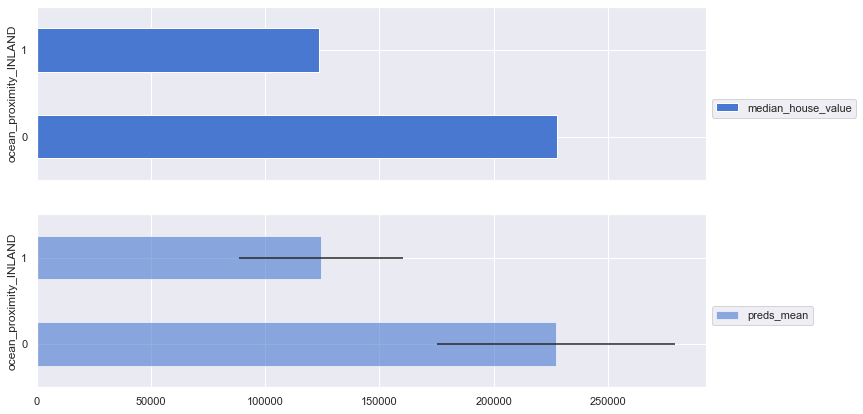

In [ ]:
# prepare figure 
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)

# plot ground truth
preds_quality.plot('ocean_proximity_INLAND', 'median_house_value', 'barh', ax=ax0)
# put legend outside plot
ax0.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

# plot preds
preds_quality.plot('ocean_proximity_INLAND', 'preds_mean', 'barh', xerr='preds_std', alpha=0.6, ax=ax1)
# put legend outside plot
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

plt.show()

The error bars in the plot indicate how confident the model is at predicting each category.  Alternatively, we can compare the _distribution_ of values to inspect how close the predictions match the ground truth. For example, for housing districts where `ocean_proximity_INLAND` is 0 we have:

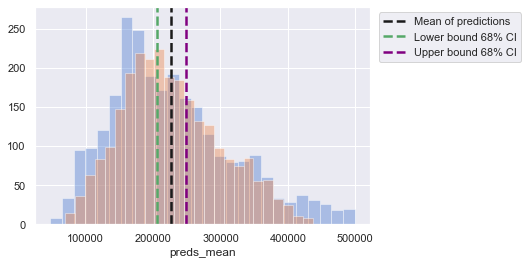

In [ ]:
sample = valid_copy.copy().loc[valid_copy["ocean_proximity_INLAND"] == 0]
sample_mean = sample['preds_mean'].mean()
sample_std = sample['preds_std'].std()
lower_bound = sample_mean - sample_std
upper_bound = sample_mean + sample_std

sns.distplot(
    sample["median_house_value"], kde=False,
)
sns.distplot(sample["preds_mean"], kde=False)
plt.axvline(
    x=sample_mean,
    linestyle="--",
    linewidth=2.5,
    label="Mean of predictions",
    c="k",
)
plt.axvline(
    x=lower_bound,
    linestyle="--",
    linewidth=2.5,
    label="Lower bound 68% CI",
    c="g",
)
plt.axvline(
    x=upper_bound,
    linestyle="--",
    linewidth=2.5,
    label="Upper bound 68% CI",
    c="purple",
)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left");

In general, we expect our models to perform best on categories that are most frequent in the data. One way to validate this hypothesis is by calculating the ratio of the standard deviation of the predictions to the predictions themselves:

In [ ]:
preds_quality = valid_copy[cols].groupby("ocean_proximity_INLAND", as_index=True).mean()
(preds_quality["preds_std"] / preds_quality["preds_mean"]).sort_values(ascending=False)

ocean_proximity_INLAND
1    0.288622
0    0.228371
dtype: float64

What the above tells us is that our predictions are less confident (i.e. higher variance) for housing districts that are inland - indeed looking at our bar plot we see these categories are under-represented in the data!

In general, confidence intervals serve two main purposes:

* We can identify which categories the model is less confident about and investigate further
* We can identify which rows in the data the model is not confident about. This is particularly important when deploying models to production, where e.g. we need to decide how to evaluate the model's predictions for a _single_ housing district.

## Feature importance

One drawback with the confidence interval analysis is that we need to drill-down into each feature to see where the model is making mistakes. In practice, we can get a global view by ranking each feature in terms of its importance to the model's predictions. In scikit-learn, the Random Forest model has an attribute called `feature_importances_` that we can use to rank each feature:

In [ ]:
def rf_feature_importance(fitted_model, df):
    return pd.DataFrame(
        {"Column": df.columns, "Importance": fitted_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

Let's use this function to calculate the feature importance for our fitted model:

In [ ]:
# expected shape - (n_features, 2)
feature_importance = rf_feature_importance(model, X)

# peek at top 10 features
feature_importance[:10]

,Column,Importance
7,median_income,0.248165
14,ocean_proximity_INLAND,0.135266
13,population_per_household,0.088856
9,postal_code,0.088172
0,longitude,0.080466
12,bedrooms_per_room,0.070059
1,latitude,0.066439
10,rooms_per_household,0.048305
2,housing_median_age,0.030146
8,city,0.022991


From the table we see that `median_income`, `ocean_proximity_INLAND`, and `population_per_household` are the most important features - this is not entirely surprising since income and house location seem to be good indicators of house value. We can also plot the feature importance to gain a visual understanding:

In [ ]:
def plot_feature_importance(feature_importance):
    return sns.barplot(y="Column", x="Importance", data=feature_importance, color='b')

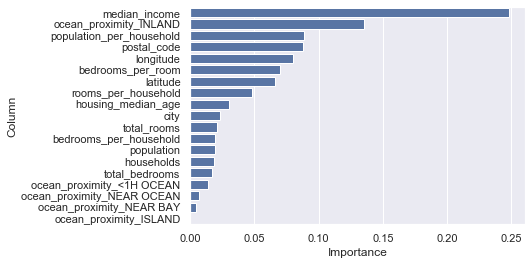

In [ ]:
plot_feature_importance(feature_importance);

In nearly every real-world dataset, this is what the feature importance looks like: a handful of columns are very important, while most are not. The powerful aspect of this approach is that is _focuses our attention_ on which features we should investigate further and which ones we can safely ignore.

> Warning: The feature importance analysis above can be biased and has a tendency to inflate the importance of continuous features or  categorical features with high cardinality (i.e. many unique categories). See the Beware Default Random Forest Importances article in the references for more information.

## Drop uninformative features

From the feature importance plot above, we can see there are only a handful of informative features - let's use this insight to make a simpler model by dropping uninformative columns from our data:

In [ ]:
feature_importance_threshold = 0.03
cols_to_keep = feature_importance[
    feature_importance['Importance'] > feature_importance_threshold
]['Column']

len(cols_to_keep)

9

In [ ]:
# create a copy of the data with selected columns and create new train / test set
X_keep = X.copy()[cols_to_keep]
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [ ]:
X_keep.head()

,median_income,ocean_proximity_INLAND,population_per_household,postal_code,longitude,bedrooms_per_room,latitude,rooms_per_household,housing_median_age
0,8.3252,0,2.555556,94705,-122.23,0.146591,37.88,6.984127,41.0
1,8.3014,0,2.109842,94611,-122.22,0.155797,37.86,6.238137,21.0
2,7.2574,0,2.802260,94618,-122.24,0.129516,37.85,8.288136,52.0
3,5.6431,0,2.547945,94618,-122.25,0.184458,37.85,5.817352,52.0
4,3.8462,0,2.181467,94618,-122.25,0.172096,37.85,6.281853,52.0


As a sanity check, let's ensure the model's prediction have not gotten worse with the reduced data (recall we had $R^2 = 0.91$ on the validation set):

In [ ]:
model = RandomForestRegressor(
    n_estimators=40, min_samples_leaf=1, n_jobs=-1, oob_score=True, random_state=42
)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 16622.874
R^2 on train: 0.97
RMSE on valid: 43873.09
R^2 on valid: 0.8
OOB R^2: 0.789


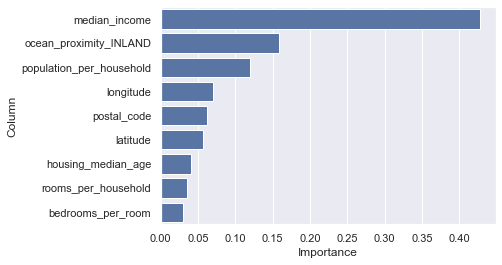

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

We've now got a model that isn't really more predictive than our baseline, but it's much simpler - it has just 9 features instead of 19 and we now know that `median_income` and `ocean_proximity_INLAND` are particularly important features to focus on.

---

#### Exercise #2

Go through the top 3 features and use plots with `seaborn` to gain insights into things like the following:

* What is the relationship between each feature and the target `median_house_value`?
* What do the distribution / bar plots look like for continuous / categorical columns?

---

## Removing redundant features

Looking at our feature importance plots, we can see that there are some features that seem to be related to each other (e.g. the square footage features like `rooms_per_household` and `bedrooms_per_room`). Features like this are potentially measuring the same thing, so we can use a special technique called _**hierarchical clustering**_ to produce something called a _**dendogram**_ that will tell us which pairs of features are similar:

In [ ]:
def plot_dendogram(X):
    """Plots a dendogram to see which features are related."""
    # calculate correlation coefficient
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    # convert to distance matrix
    corr_condensed = hc.distance.squareform(1 - corr)
    # perform clustering
    z = hc.linkage(corr_condensed, method="average")
    # plot dendogram
    fig = plt.figure(figsize=(16, 10))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16
    )
    plt.show()

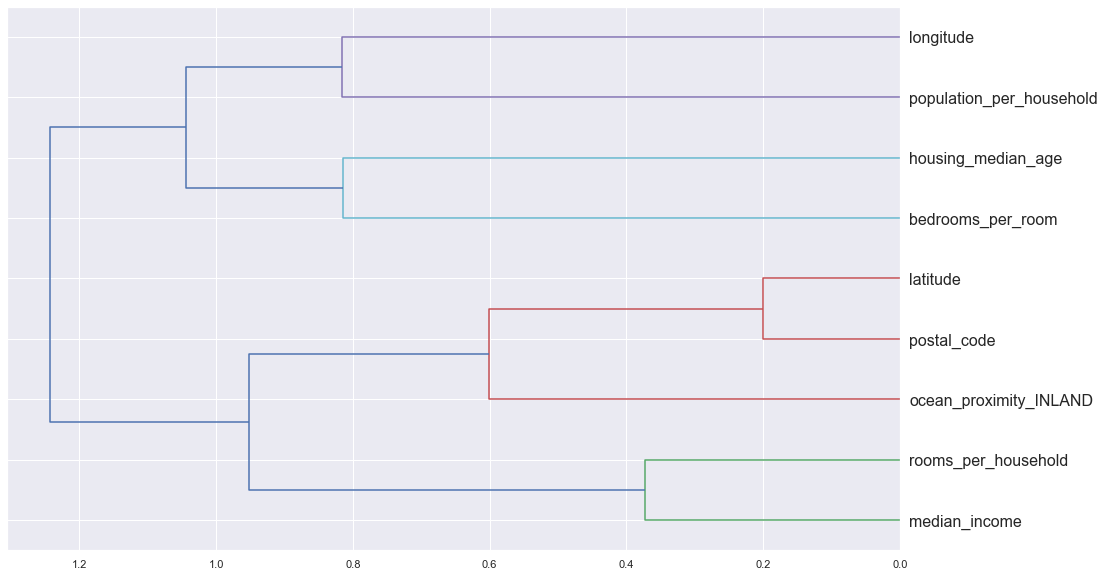

In [ ]:
plot_dendogram(X_keep)

From the plot we see that quantities like `latitude` and `postal_code` are grouped together and similar (as we might expect). Note that we used Spearman's rank correlation coefficient to calculate notions of similarity - this is useful for finding non-linear correlations that may be missed by Pearson's correlation coefficient.

To examine these correlations a bit deeper, let's create a function that trains a Random Forest on subsets of the data where one of the columns is removed and see in which cases the OOB score does not get worse:

In [ ]:
def get_oob(df):
    model = RandomForestRegressor(
        n_estimators=40, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42
    )
    X, _ = train_test_split(df, test_size=0.2, random_state=42)
    model.fit(X, y_train)
    return model.oob_score_

In [ ]:
# calculate reference value
get_oob(X_keep)

0.8021265907435767

In [ ]:
for column in (
    "longitude",
    "population_per_household",
    "housing_median_age",
    "bedrooms_per_room",
    "latitude",
    "postal_code",
    "rooms_per_household",
    "median_income",
):
    print(column, get_oob(X_keep.drop(column, axis=1)))

longitude 0.7728875237498377
population_per_household 0.7901969073954147
housing_median_age 0.7921744780471269
bedrooms_per_room 0.8033772050439794
latitude 0.7764470270681797
postal_code 0.7817819559028422
rooms_per_household 0.8039031326542978
median_income 0.7947438916177811


Here we're looking for columns where the OOB score did not drop much, say around the third decimal place. Let's see what happens to our OOB score when we drop these candidate columns:

In [ ]:
cols_to_drop = [
    'bedrooms_per_room',
    "rooms_per_household",
]
get_oob(X_keep.drop(cols_to_drop, axis=1))

0.805703437136301

The OOB score increases fractionally which is good since we're looking for a simpler model - let's drop these columns and run the full model again:

In [ ]:
X_keep.drop(cols_to_drop, axis=1, inplace=True)
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=40, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 15876.383
R^2 on train: 0.973
RMSE on valid: 41855.649
R^2 on valid: 0.818
OOB R^2: 0.806


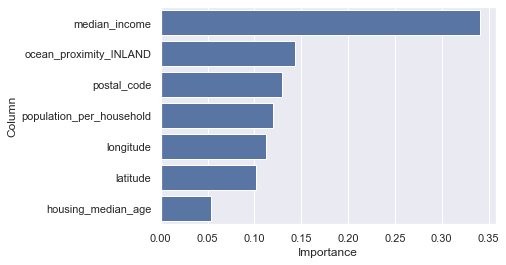

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

## Our final model

Now that we have simplified our model, let's create a huge Random Forest to see if we can squeeze a bit more performance:

In [ ]:
model = RandomForestRegressor(
    n_estimators=1000, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42
)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 14963.277
R^2 on train: 0.976
RMSE on valid: 41200.693
R^2 on valid: 0.823
OOB R^2: 0.823


Our final model achieves around 5% better performance compared to our naive model with 10 trees from lesson 4, but it is _much simpler_ - we've reduced the features from 19 down to 7! Moreover we've identified which features are most important, let's plot them out for the final visual comparison:

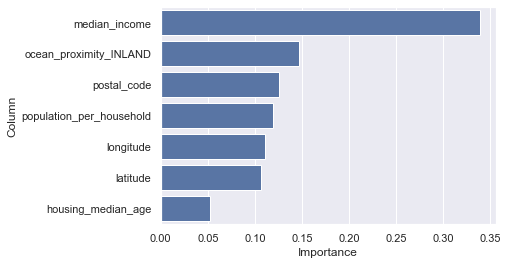

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

### Save model to disk

Finally let's save this model to disk for later use or if we want to deploy it to production:

In [ ]:
import pickle

with open(DATA/'housing_model.pkl', mode='wb') as file:
    pickle.dump(model, file)

In [ ]:
# sanity check
with open(DATA/'housing_model.pkl', mode='rb') as file:
    model = pickle.load(file)

In [ ]:
print_rf_scores(model)

RMSE on train: 14963.277
R^2 on train: 0.976
RMSE on valid: 41200.693
R^2 on valid: 0.823
OOB R^2: 0.823


> Note: We often use the `with` statement to read or write data in Python as this automatically takes care of closing the file once we have finished with it. The `mode` argument controls how we want to open the file, where `'rb'` (read) and `'wb'` (write) correspond to opening in binary mode.

---

#### Exercise #3

By this stage you've now learned all the key steps needed to clean data, train a machine learning model, and interpret the results! Try applying the techniques you have learned to Kaggle's [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. Don't spend too much time trying to build a perfect model - the purpose of this exercise is to get familiar with downloading a new dataset, understanding the evaluation metric, and submitting your predictions to the Kaggle platform. To get started:

* Create an account on [Kaggle](https://www.kaggle.com/)
* Download the data from [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

When you have your predictions ready, submit them [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submissions) for evaluation on the public leaderboard!

Hint #1: Kaggle provides 2 datasets called `train.csv` and `test.csv`, where the latter is missing the target column `SalePrice`. Your task is to build a regression model on `train.csv` and then use that model to make _predictions_ on `test.csv`. 

Hint #2: A closer look at Kaggle's evaluation metric shows that we actually want the RMSE between the _logarithms_ of the predicted and actual house prices:

> Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

How might you handle this? You may find NumPy's [log function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) to be useful here.

Hint #3: You may find the `convert_strings_to_categories` function from lesson 3 to be useful. You can import it from the `dslectures` library as follows

```python
from dslectures.core import convert_strings_to_categories
```

Hint #4: When you use the median to fill missing values in the training set, you should use the _same_ median for the test set. See p.61 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by A. Geron.

---
